[*********************100%***********************]  1 of 1 completed


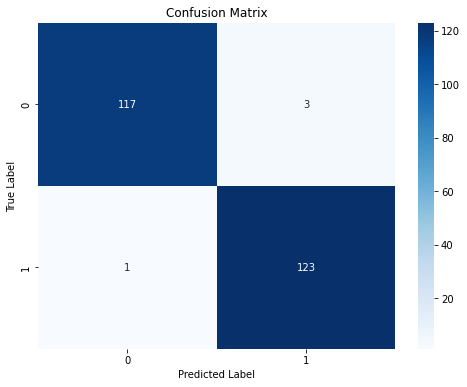

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       120
           1       0.98      0.99      0.98       124

    accuracy                           0.98       244
   macro avg       0.98      0.98      0.98       244
weighted avg       0.98      0.98      0.98       244



In [1]:
import yfinance as yf
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Function to create sliding window of data
def create_sliding_window(data, window_size):
    X = []
    for i in range(len(data) - window_size - 1):
        X.append(data[i: (i + window_size)])
    return np.array(X)

# Download historical data
data = yf.download('AAPL', '2010-01-01', '2023-05-30')

# Calculate the daily returns
data['returns'] = data['Close'].pct_change()

# Drop missing values
data = data.dropna()

# Add a column 'direction' which is our target variable. 1 for positive returns, 0 for negative
data = data.copy()
data.loc[:, 'direction'] = np.where(data['returns'].shift(-1) > 0, 1, 0)

# Prepare data for SVM
X = data['returns'].values  # features
y = data['direction'].values  # target

# Create sliding window of past 5 days
window_size = 5
X = create_sliding_window(X, window_size)

# The target variable needs to be shifted accordingly
y = y[:-window_size-1]

# Scale the features
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Create a mask for the data that falls before your cutoff date
cutoff_date = pd.to_datetime('2022-05-30')
mask = data.index[:-window_size-1] < cutoff_date

# Split the data into training and test sets
X_train = X[mask]
y_train = y[mask]
X_test = X[~mask]
y_test = y[~mask]

# Train the SVM classifier with GridSearchCV for basic parameter tuning
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svm.SVC(probability=True), parameters)
clf.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = clf.predict(X_test)

# Print a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print a classification report
print(classification_report(y_test, y_pred))



In [2]:
# Create a DataFrame for test data
test_data = data[~mask].iloc[window_size:-window_size-1]

# Calculate probabilities for test data only
test_features = create_sliding_window(test_data['returns'].values, window_size)
test_features_scaled = scaler.transform(test_features)
probs = clf.predict_proba(test_features_scaled)[:, 1]

# Assign the probabilities to 'predicted_probability' column in the test data
test_data['predicted_probability'] = probs

# Backtest
initial_balance = 10000  
balance = initial_balance
num_shares = 0

# Loop through the test data
for _, row in test_data.iterrows():
    # invest a fraction of balance based on confidence of prediction
    investment_fraction = row['predicted_probability']
    investment = balance * investment_fraction
    num_shares += investment / row['Close']
    balance -= investment

# add value of any remaining shares to balance
balance += num_shares * test_data['Close'].iloc[-1]

print('Final balance:', balance)


ValueError: Item wrong length 3366 instead of 3372.